In [2]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import cv2
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
import pandas as pd

WORK_DIR = Path(Path.cwd()).parent
sys.path.append(str(WORK_DIR))
from src.datasets import get_dataset, get_dataloader
from src.utils import parse_data_cfg, IMG, EK, LMDB, DATA_DIR, FPHA

In [3]:
exp_folder = ''
cfgname = 'ek_hpo_action_noun_exp'
cfg = parse_data_cfg(WORK_DIR/'data_cfg'/exp_folder/(cfgname + '.cfg'))
epoch = 0
exp_dir = cfg["exp_dir"]
data_split = 'train'
split_set = cfg[data_split + '_set']

In [4]:
epic_root = Path(DATA_DIR)/'EPIC_KITCHENS_2018'
epic_action_data =  os.path.join(epic_root, 'annotations', 'EPIC_train_action_labels.csv')
epic_action_data = pd.read_csv(epic_action_data)
action_verb_class = np.sort(epic_action_data.verb_class.unique())
action_noun_class = np.sort(epic_action_data.noun_class.unique())
action_dict = EK.rev_lin_id(action_verb_class)
noun_dict = EK.rev_lin_id(action_noun_class)

# Visualize Dataloader

In [4]:
dataset_kwargs = {'split_set': split_set}
dataset   = get_dataset(cfg, dataset_kwargs)
sampler   = None
shuffle   = cfg['shuffle']
kwargs = {'batch_size'  :   int(cfg['batch_size']),
          'shuffle'     :   shuffle,
          'num_workers' :   int(cfg['num_workers']),
          'pin_memory'  :   True}
data_loader = get_dataloader(dataset, sampler, kwargs)

In [ ]:
idx = 0 
for i, (img, uvd_gt) in enumerate(data_loader):
    if i == idx:
        batch_size = img.shape[0]
        img = img.cpu().numpy()
        img = np.swapaxes(img, 2, 3)
        img = np.swapaxes(img, 1, 3)
        img = IMG.scale_img_255(img)
        uvd_gt = uvd_gt.cpu().numpy()
        uvd_gt = np.squeeze(uvd_gt)
        break
    i += 1

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
idx = 0
for i in range(4):
    for j in range(4):
        k = np.ravel_multi_index((i, j), (4, 4))
        if k >= len(img):
            break        
        cur_img = img[idx]
        u = uvd_gt[idx]        
        ax[i, j].imshow(cur_img)
        u = IMG.scale_points_WH(u, (1,1), (cur_img.shape[0], cur_img.shape[1]))
        FPHA.visualize_joints_2d(ax[i, j], u[FPHA.REORDER_IDX], joint_idxs=False)
        idx += 1

# Evaluation

In [5]:
# Roots
root = Path(DATA_DIR)/'EPIC_KITCHENS_2018'
# Loading
image_tmpl = "img_{:05d}.jpg"
with open(root/(split_set), 'r') as f:
    img_labels = f.read().splitlines()
img_path_list    = [i.split(' ')[0] for i in img_labels]
length_path_list = [int(i.split(' ')[1]) for i in img_labels]
action_id_list   = [int(i.split(' ')[2]) for i in img_labels]
noun_id_list     = [int(i.split(' ')[3]) for i in img_labels]

noun_id    = []
action_id  = []
img_path   = []
for path, length, action, noun in zip(img_path_list, length_path_list, action_id_list, noun_id_list):
    for idx in range(length):
        img_path.append(os.path.join(path, image_tmpl.format(idx)))
        action_id.append(action)
        noun_id.append(noun)

In [6]:
pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_best.txt'.format(epoch, data_split))
pred_uvd = np.reshape(np.loadtxt(pred_file), (-1, 21, 3))
pred_uvd = IMG.scale_points_WH(pred_uvd, (1, 1), (416, 416))
pred_uvd[..., 2] *= 1000
pred_xyz = FPHA.uvd2xyz_color(pred_uvd)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_conf.txt'.format(epoch, data_split))
pred_conf = np.loadtxt(pred_file)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_top5_action.txt'.format(epoch, data_split))
pred_top5_action = np.loadtxt(pred_file)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_top5_noun.txt'.format(epoch, data_split))
pred_top5_noun = np.loadtxt(pred_file)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_action_dist.txt'.format(epoch, data_split))
pred_action_dist = np.loadtxt(pred_file)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_noun_dist.txt'.format(epoch, data_split))
pred_noun_dist = np.loadtxt(pred_file)


# Hand

/4TB/aaron/EPIC_KITCHENS_2018/EK_frames/P01/P01_09_1510_take_olive/img_00009.jpg
GT action: take
GT noun: olive
Predicted action: break
Predicted noun: recipe


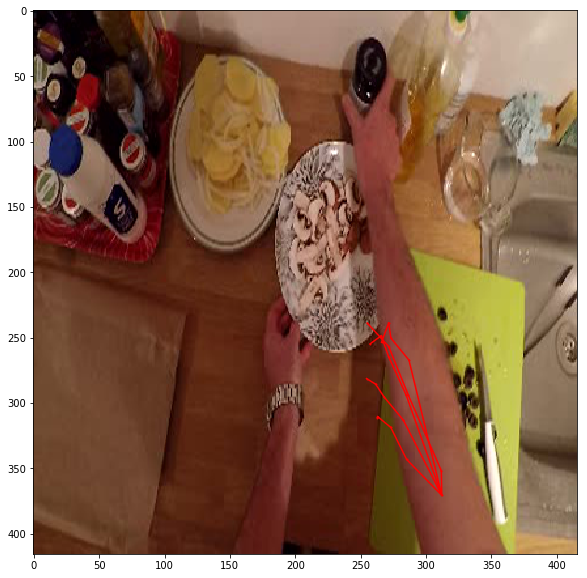

In [9]:
idx = 9
print(img_path[idx])
print('GT action:', EK.get_class_name(action_dict[action_id[idx]], 'verb'))
print('GT noun:', EK.get_class_name(noun_dict[noun_id[idx]], 'noun'))
print('Predicted action:', EK.get_class_name(action_dict[pred_top5_action[int(idx)][0]], 'verb'))
print('Predicted noun:', EK.get_class_name(noun_dict[pred_top5_noun[int(idx)][0]], 'noun'))
img = np.asarray(Image.open(img_path[idx]))
img = IMG.resize_img(img, (416, 416))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
FPHA.visualize_joints_2d(ax, pred_uvd[idx][FPHA.REORDER_IDX], joint_idxs=False, c='r')

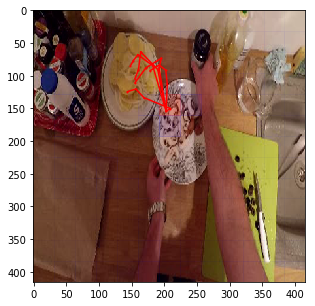

In [7]:
max_idx = []
# get the best idx for each 2D cell
for i in range(len(pred_conf[idx])//5):
    max_idx.append(i*5 + np.argmax(pred_conf[idx][i*5:i*5+5]))

fig, ax = plt.subplots(figsize=(5,5))
pred_uvd_416 = pred_uvd[idx]
FPHA.visualize_joints_2d(ax, pred_uvd_416[FPHA.REORDER_IDX], joint_idxs=False, c='r')
# FPHA.visualize_joints_2d(ax, uvd_gt_416[FPHA.REORDER_IDX], joint_idxs=False, c='b')
img_rsz = IMG.resize_img(img, (416, 416))
ax.imshow(img_rsz.astype('uint32'))

# red is the best
# yellow is anything over 0.9
import matplotlib.patches as patches
for i in range(len(max_idx)):
    index = np.unravel_index(i, (13, 13))
    x = index[1]
    y = index[0]
    al = pred_conf[idx][max_idx[i]]
    if al == np.amax(pred_conf[idx]):
        c = 'r'
    elif al <= 0.8:
        c = 'b'
    else:
        c = 'y'
    rect = patches.Rectangle((x*32,y*32),32,32,linewidth=1, edgecolor=c, facecolor=c, fill=True, alpha=al)
    ax.add_patch(rect)

# Action

In [12]:
top1_cls_acc = {}
top5_cls_acc = {}
total_gt = {}
for pred, gt in zip(pred_top5_action, action_id):
    if gt not in top1_cls_acc:
        top1_cls_acc[gt] = 0
    if gt not in top5_cls_acc:
        top5_cls_acc[gt] = 0
    if gt not in total_gt:
        total_gt[gt] = 0

    if pred[0] == gt:
        top1_cls_acc[gt] += 1
    if gt in pred:
        top5_cls_acc[gt] += 1
    
    total_gt[gt] += 1
    
cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 Per-frame mean-class ACTION accuracy:', np.mean(cls_mean)*100)

cls_mean = []
for k in top5_cls_acc.keys():
     cls_mean.append(top5_cls_acc[k]/total_gt[k])
print('Top 5 Per-frame mean-class ACTION accuracy:', np.mean(cls_mean)*100)

Top 1 Per-frame mean-class ACTION accuracy: 83.76961719360587
Top 5 Per-frame mean-class ACTION accuracy: 97.86792721418706


In [52]:
seq_dict = {}
gt_dict = {}
for path, pred, gt in zip(img_path, pred_action_dist, action_id):
    if path[:-10] not in seq_dict:
        seq_dict[path[:-10]] = []
    if path[:-10] not in gt_dict:
        gt_dict[path[:-10]] = gt 
    
    seq_dict[path[:-10]].append(pred)

top1_cls_acc = {}
top5_cls_acc = {}
total_gt = {}
number_of_frames_per_sequence = 10
for k in seq_dict.keys():
    new_seq_dict = []
    new_range = np.linspace(0, len(seq_dict[k]) - 1, number_of_frames_per_sequence).astype('uint32')
    for i in new_range:
        new_seq_dict.append(seq_dict[k][i])
    avg_dist = np.mean(new_seq_dict, axis=0)
    top5_pred = avg_dist.argsort()[-5:][::-1]
    if gt_dict[k] not in top1_cls_acc:
        top1_cls_acc[gt_dict[k]] = 0
    if gt_dict[k] not in top5_cls_acc:
        top5_cls_acc[gt_dict[k]] = 0
    if gt_dict[k] not in total_gt:
        total_gt[gt_dict[k]] = 0
        
    if top5_pred[0] == gt_dict[k]:
        top1_cls_acc[gt_dict[k]] += 1
    if gt_dict[k] in top5_pred:
        top5_cls_acc[gt_dict[k]] += 1
        
    total_gt[gt_dict[k]] += 1
cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 distribution consensus mean-class ACTION accuracy:', np.mean(cls_mean)*100)

cls_mean = []
for k in top5_cls_acc.keys():
     cls_mean.append(top5_cls_acc[k]/total_gt[k])
print('Top 5 distribution consensus mean-class ACTION accuracy:', np.mean(cls_mean)*100)

Top 1 distribution consensus mean-class ACTION accuracy: 88.83384426031485
Top 5 distribution consensus mean-class ACTION accuracy: 98.92592592592592


In [26]:
# TODO: Optimize this mess
cur_seq = img_path[0][:-10]
cur_gt = action_id[0]
top1_cls_acc = {}
total_gt = {}
seq_pred = []
for path, pred, gt in zip(img_path, pred_top5_action, action_id):
    if path[:-10] == cur_seq:
        seq_pred.append(pred[0])
    else:
        if cur_gt not in top1_cls_acc:
            top1_cls_acc[cur_gt] = 0
        if cur_gt not in total_gt:
            total_gt[cur_gt] = 0        

        # totalling
        total = len(seq_pred)
        pred_class = np.bincount(seq_pred)
        pred_class = np.argmax(pred_class)
        if pred_class == cur_gt:
            top1_cls_acc[cur_gt] += 1
        total_gt[cur_gt] += 1
        
        # init
        seq_pred = []
        seq_pred.append(pred[0])
        cur_gt = gt
        if cur_gt not in top1_cls_acc:
            top1_cls_acc[cur_gt] = 0
        if cur_gt not in total_gt:
            total_gt[cur_gt] = 0        
        
if cur_gt not in top1_cls_acc:
    top1_cls_acc[cur_gt] = 0
if cur_gt not in total_gt:
    total_gt[cur_gt] = 0        

# totalling
total = len(seq_pred)
pred_class = np.bincount(seq_pred)
pred_class = np.argmax(pred_class)
if pred_class == cur_gt:
    top1_cls_acc[cur_gt] += 1
total_gt[cur_gt] += 1

cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 video consensus mean-class ACTION accuracy:', np.mean(cls_mean)*100)

Top 1 video consensus mean-class ACTION accuracy: 83.82627377949541


# Noun

In [5]:
top1_cls_acc = {}
top5_cls_acc = {}
total_gt = {}
for pred, gt in zip(pred_top5_noun, noun_id):
    if gt not in top1_cls_acc:
        top1_cls_acc[gt] = 0
    if gt not in top5_cls_acc:
        top5_cls_acc[gt] = 0
    if gt not in total_gt:
        total_gt[gt] = 0

    if pred[0] == gt:
        top1_cls_acc[gt] += 1
    if gt in pred:
        top5_cls_acc[gt] += 1
    
    total_gt[gt] += 1
    
cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 Per-frame mean-class NOUN accuracy:', np.mean(cls_mean)*100)

cls_mean = []
for k in top5_cls_acc.keys():
     cls_mean.append(top5_cls_acc[k]/total_gt[k])
print('Top 5 Per-frame mean-class NOUN accuracy:', np.mean(cls_mean)*100)

NameError: name 'pred_top5_noun' is not defined

In [32]:
seq_dict = {}
gt_dict = {}
for path, pred, gt in zip(img_path, pred_noun_dist, noun_id):
    if path[:-10] not in seq_dict:
        seq_dict[path[:-10]] = []
    if path[:-10] not in gt_dict:
        gt_dict[path[:-10]] = gt 
    
    seq_dict[path[:-10]].append(pred)

top1_cls_acc = {}
top5_cls_acc = {}
total_gt = {}
for k in seq_dict.keys():
    avg_dist = np.mean(seq_dict[k], axis=0)
    top5_pred = avg_dist.argsort()[-5:][::-1]
    if gt_dict[k] not in top1_cls_acc:
        top1_cls_acc[gt_dict[k]] = 0
    if gt_dict[k] not in top5_cls_acc:
        top5_cls_acc[gt_dict[k]] = 0
    if gt_dict[k] not in total_gt:
        total_gt[gt_dict[k]] = 0
        
    if top5_pred[0] == gt_dict[k]:
        top1_cls_acc[gt_dict[k]] += 1
    if gt_dict[k] in top5_pred:
        top5_cls_acc[gt_dict[k]] += 1
        
    total_gt[gt_dict[k]] += 1
cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 distribution consensus mean-class NOUN accuracy:', np.mean(cls_mean)*100)

cls_mean = []
for k in top5_cls_acc.keys():
     cls_mean.append(top5_cls_acc[k]/total_gt[k])
print('Top 5 distribution consensus mean-class NOUN accuracy:', np.mean(cls_mean)*100)

Top 1 distribution consensus mean-class NOUN accuracy: 88.74612920943432
Top 5 distribution consensus mean-class NOUN accuracy: 99.74358974358975


In [33]:
# TODO: Optimize this mess
cur_seq = img_path[0][:-10]
cur_gt = noun_id[0]
top1_cls_acc = {}
total_gt = {}
seq_pred = []
for path, pred, gt in zip(img_path, pred_top5_noun, noun_id):
    if path[:-10] == cur_seq:
        seq_pred.append(pred[0])
    else:
        if cur_gt not in top1_cls_acc:
            top1_cls_acc[cur_gt] = 0
        if cur_gt not in total_gt:
            total_gt[cur_gt] = 0        

        # totalling
        total = len(seq_pred)
        pred_class = np.bincount(seq_pred)
        pred_class = np.argmax(pred_class)
        if pred_class == cur_gt:
            top1_cls_acc[cur_gt] += 1
        total_gt[cur_gt] += 1
        
        # init
        seq_pred = []
        seq_pred.append(pred[0])
        cur_gt = gt
        if cur_gt not in top1_cls_acc:
            top1_cls_acc[cur_gt] = 0
        if cur_gt not in total_gt:
            total_gt[cur_gt] = 0        
        
if cur_gt not in top1_cls_acc:
    top1_cls_acc[cur_gt] = 0
if cur_gt not in total_gt:
    total_gt[cur_gt] = 0        

# totalling
total = len(seq_pred)
pred_class = np.bincount(seq_pred)
pred_class = np.argmax(pred_class)
if pred_class == cur_gt:
    top1_cls_acc[cur_gt] += 1
total_gt[cur_gt] += 1

cls_mean = []
for k in top1_cls_acc.keys():
     cls_mean.append(top1_cls_acc[k]/total_gt[k])
print('Top 1 video consensus mean-class NOUN accuracy:', np.mean(cls_mean)*100)

Top 1 video consensus mean-class NOUN accuracy: 86.00117736206738


# Detect

In [6]:
import torch

from src.models import get_model
from src.utils import EK

torch.cuda.set_device(1)
cfg['batch_size'] = 1
model = get_model(cfg, False, epoch, None, None)

In [9]:
# Image
idx = 0
img = np.asarray(Image.open(img_path[idx]))
uvd_out, action_out, noun_out, top_idx = model.detect(img)
print(top_idx)

tensor([291], device='cuda:1')


In [ ]:
out_idx = 291

fig, ax = plt.subplots(figsize=(10, 10))
img_rsz = IMG.resize_img(img, (416, 416))
ax.imshow(img_rsz)
# for out_idx in range(291):
FPHA.visualize_joints_2d(ax, uvd_out[out_idx][FPHA.REORDER_IDX], joint_idxs=False)